In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np

In [4]:
# HOG FEATURES: 
# The histogram of gradients is straightforward feature extration procedure that was developed  in the 
# context of identifying pedestrians within images

In [6]:
from skimage import data, color, feature
import skimage.data

In [7]:
image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

Text(0.5, 1.0, 'visualization of HOG features')

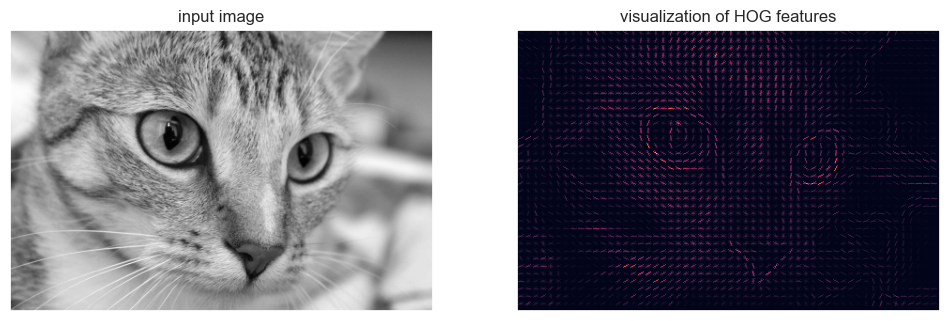

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features')

In [10]:
# HOG IN ACTION : A SIMPLE FACE DETECTOR

In [12]:
from sklearn.datasets import fetch_lfw_people
import shutil

# Path to the dataset cache
cache_path = r'C:\Users\Family\scikit_learn_data\lfw_home'

# Delete the cache
shutil.rmtree(cache_path, ignore_errors=True)


In [ ]:
# 1. Obtain a set of postive samples

In [14]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=50, resize=0.4)
positive_patches = faces.images
positive_patches.shape

(1560, 50, 37)

In [15]:
# Obtain a set of negative training samples

In [17]:
from skimage import data, color

imgs_to_use = ['camera', 'text', 'coins', 'moon', 'page', 'clock', 
               'immunohistochemistry', 'chelsea', 'coffee', 'hubble_deep_field']

images = []
for name in imgs_to_use:
    img = getattr(data, name)()
    # Only convert to grayscale if the image is RGB
    if img.ndim == 3:  # Check if the image has 3 dimensions (i.e., it's an RGB image)
        img = color.rgb2gray(img)
    images.append(img)

In [18]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = \
    tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])

    if scale!=1:
        patches = np.array([transform.resize(patch, patch_size) for patch in patches])
    return patches

In [19]:
negative_patches = np.vstack([extract_patches(im, 1000, scale) for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 50, 37)

In [20]:
# We now have 30,000 suitable image patches that do not contain faces 

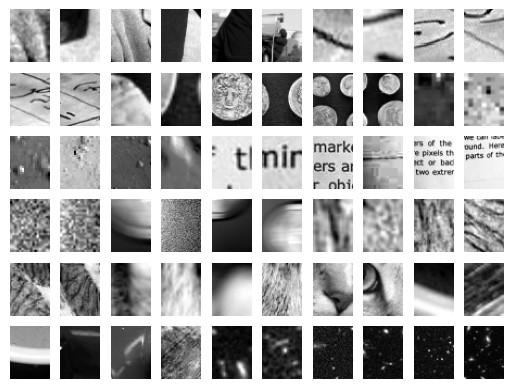

In [21]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500*i], cmap='gray')
    axi.axis('off')

In [22]:
# 3. Combine sets and extrach HOG features

In [23]:
from itertools import chain
x_train = np.array([feature.hog(im) for im in chain(positive_patches, negative_patches)])
y_train = np.zeros(x_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [24]:
x_train.shape

(31560, 648)

In [25]:
# 4. Train a support vector machine

In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [29]:
cross_val_score(GaussianNB(), x_train, y_train)

array([0.99176172, 0.99176172, 0.99366286, 0.99730672, 0.99556401])

In [34]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1.0, 2.0, 4.0, 8.0]}
model = LinearSVC()
grid = GridSearchCV(model, param_grid)
grid.fit(x_train, y_train)
grid.best_score_

c:\Users\Family\DS_PRACTICE\ML_MODELS\venv_mlmodels\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Family\DS_PRACTICE\ML_MODELS\venv_mlmodels\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Family\DS_PRACTICE\ML_MODELS\venv_mlmodels\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Family\DS_PRACTICE\ML_MODELS\venv_mlmodels\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` expli

0.9970215462610901

In [35]:
grid.best_params_

{'C': 1.0}

In [36]:
# Let's take the best estimator and retrain it on the full dataset

In [37]:
mode = grid.best_estimator_
model.fit(x_train, y_train)

c:\Users\Family\DS_PRACTICE\ML_MODELS\venv_mlmodels\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [38]:
# 5. FIND FACES IN NEW IMAGE

In [39]:
import skimage.color
import skimage.transform


test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

(-0.5, 139.5, 159.5, -0.5)

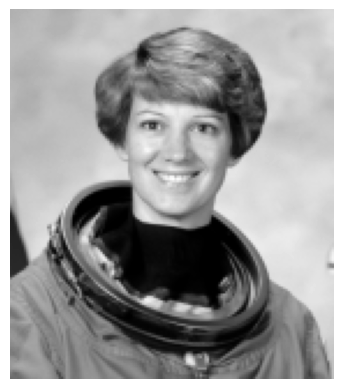

In [40]:
plt.imshow(test_image, cmap='gray')
plt.axis('off')

In [41]:
# Let's create a window that iterates over patches of this image and compute HOG features
# for each patch

In [42]:
def sliding_window(img, patch_size=positive_patches[0].shape, istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale*s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1]-Ni, jstep):
            patch = img[i:i + Ni, j:j+Nj]
            if scale!=1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

In [43]:
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(2475, 648)

In [44]:
# Finally we can take these HOG-featured patches and use our model to evaluate wether each patch contains a face

In [45]:
labels = mode.predict(patches_hog)
labels.sum()

13.0

In [46]:
# Lets draw the patches as rectangle

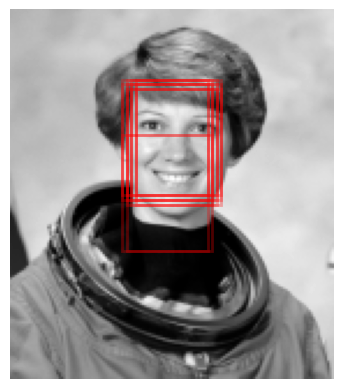

In [48]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels==1]:
    ax.add_patch(plt.Rectangle((j,i), Nj, Ni, edgecolor='red', alpha=0.3, lw=2, facecolor='none'))

In [49]:
# All of the detected patches overlap and found the face in the image. Not bad for a few lines of python!